# Time-series anomaly detection methods for unlabeled data

Goal:
To detect anomalies in network traffic using unsupervised learning and compare each model's results

Models Used:
- K-means
- DBSCAN
- Isolation Forest


Dataset:
- Dataset: CESNET-TimeSeries24
https://zenodo.org/records/13382427
- Details:
  - The datapoints represent the aggregated behavior of IP addresses within a window of 10 minutes.
  - Uses campus/institution data which would look different to datasets generated in different circumstances
  - Unlabeled

Other Relevant research papers used in creation of notebook:
- https://www.nature.com/articles/s41597-025-04603-x
- https://www.mdpi.com/1424-8220/23/5/2844
- Anomaly Detection using Clustering:
https://www.jcbi.org/index.php/Main/article/view/598


In [ ]:
import pandas as pd
import glob
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
DIRECTORY = '/content/drive/My Drive/Anomaly Detection Project'
#DIRECTORY = '/content/drive/Shared with me/Anomaly Detection Project'

Mounted at /content/drive


In [ ]:
# load training data
files = glob.glob(DIRECTORY + "/data/CESNET_agg_10_minutes/*.csv")
df = pd.concat((pd.read_csv(f) for f in files), ignore_index=True)


In [ ]:
print(df.columns)
df

Index(['id_time', 'n_flows', 'n_packets', 'n_bytes', 'n_dest_asn',
       'n_dest_ports', 'n_dest_ip', 'tcp_udp_ratio_packets',
       'tcp_udp_ratio_bytes', 'dir_ratio_packets', 'dir_ratio_bytes',
       'avg_duration', 'avg_ttl'],
      dtype='object')


,id_time,n_flows,n_packets,n_bytes,n_dest_asn,n_dest_ports,n_dest_ip,tcp_udp_ratio_packets,tcp_udp_ratio_bytes,dir_ratio_packets,dir_ratio_bytes,avg_duration,avg_ttl
0,5599,3,3,175,3.0,3.0,3.0,0.33,0.25,0.33,0.45,0.00,247.67
1,7581,6,12,604,4.0,4.0,4.0,1.00,1.00,0.33,0.36,12.23,188.33
2,7616,5,8,324,2.0,2.0,2.0,1.00,1.00,0.12,0.14,0.00,252.40
3,7624,2,4,168,2.0,2.0,2.0,1.00,1.00,0.25,0.26,0.06,154.50
4,7644,2,4,208,1.0,2.0,2.0,1.00,1.00,1.00,1.00,31.61,62.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6867533,40124,4,7,372,2.0,4.0,4.0,1.00,1.00,0.14,0.16,0.00,156.00
6867534,40156,4,7,428,4.0,4.0,4.0,0.86,0.72,0.14,0.14,0.03,154.25
6867535,40159,4,24,1413,1.0,4.0,1.0,1.00,1.00,0.17,0.13,1.60,56.00
6867536,40229,2,9,727,2.0,2.0,2.0,1.00,1.00,0.44,0.30,31.69,149.00


# Preprocessing

In [ ]:
# 1. pre processsing for CESNET dataset
#BASIC INFORMATION
print("\ndataset info:")
print(df.info())

#filling in any missing columns
missing_cols = df.columns[df.isnull().any()].tolist()

if missing_cols:
    for col in missing_cols:
        missing_pct = df[col].isnull().mean() * 100

        if df[col].dtype in ['float64', 'int64']: #numerical -> using median
            df[col] = df[col].fillna(df[col].median())
        else: #catergorical -> using mode
            mode_vals = df[col].mode()

            if not mode_vals.empty:
                mode_val = mode_vals[0]
                df[col] = df[col].fillna(mode_val)
            else:
                df[col] = df[col].fillna("Unknown")

#check duplicates
duplicates = df.duplicated().sum()

if duplicates > 0:
    df = df.drop_duplicates()
    print("duplicates removed :D")

display(df.head())


dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6867538 entries, 0 to 6867537
Data columns (total 13 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   id_time                int64  
 1   n_flows                int64  
 2   n_packets              int64  
 3   n_bytes                int64  
 4   n_dest_asn             float64
 5   n_dest_ports           float64
 6   n_dest_ip              float64
 7   tcp_udp_ratio_packets  float64
 8   tcp_udp_ratio_bytes    float64
 9   dir_ratio_packets      float64
 10  dir_ratio_bytes        float64
 11  avg_duration           float64
 12  avg_ttl                float64
dtypes: float64(9), int64(4)
memory usage: 681.1 MB
None
none yippee!
duplicates removed :D


,id_time,n_flows,n_packets,n_bytes,n_dest_asn,n_dest_ports,n_dest_ip,tcp_udp_ratio_packets,tcp_udp_ratio_bytes,dir_ratio_packets,dir_ratio_bytes,avg_duration,avg_ttl
0,5599,3,3,175,3.0,3.0,3.0,0.33,0.25,0.33,0.45,0.00,247.67
1,7581,6,12,604,4.0,4.0,4.0,1.00,1.00,0.33,0.36,12.23,188.33
2,7616,5,8,324,2.0,2.0,2.0,1.00,1.00,0.12,0.14,0.00,252.40
3,7624,2,4,168,2.0,2.0,2.0,1.00,1.00,0.25,0.26,0.06,154.50
4,7644,2,4,208,1.0,2.0,2.0,1.00,1.00,1.00,1.00,31.61,62.00


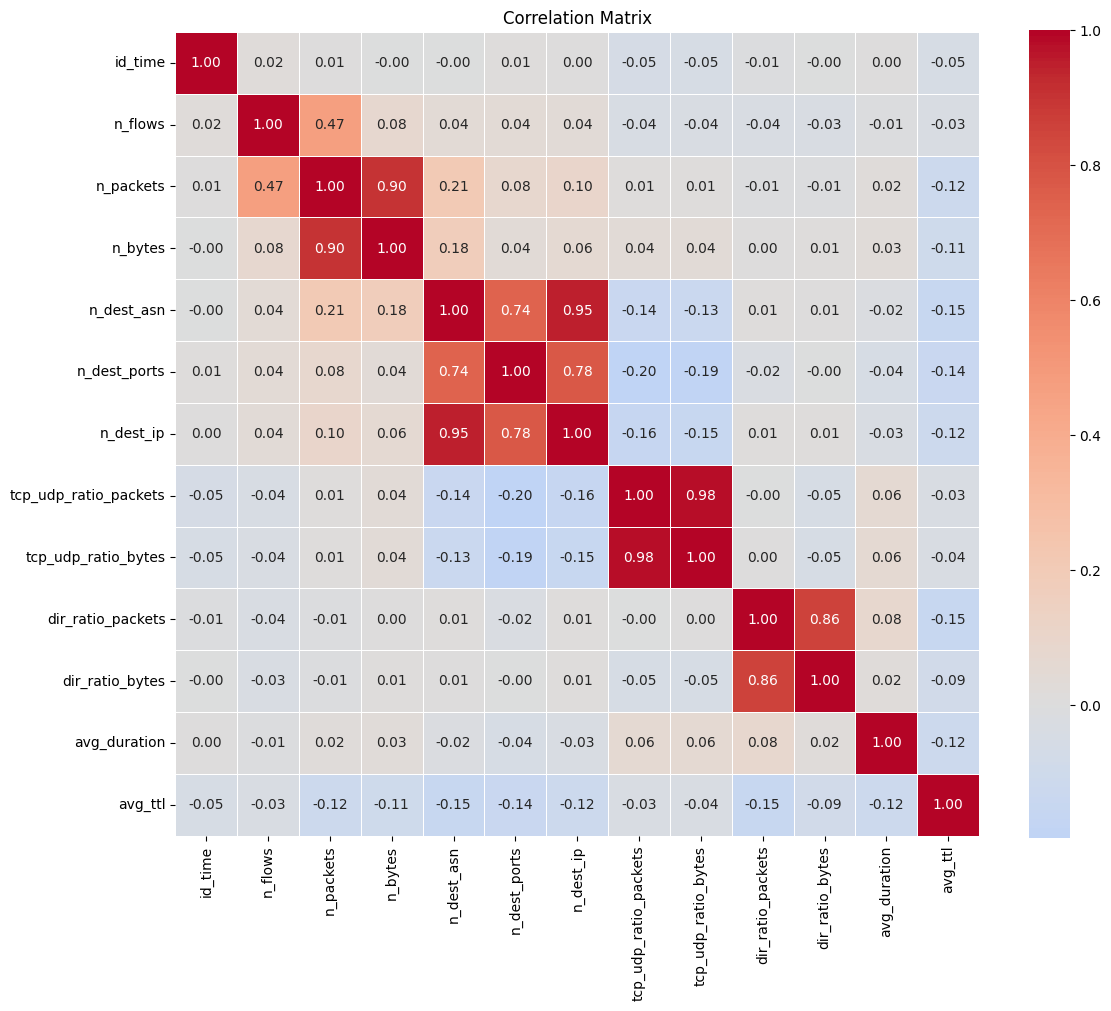


 highly correlated feature pairs:

Feature 1: n_packets, Feature 2: n_bytes, corr = 0.898084
Feature 1: n_dest_asn, Feature 2: n_dest_ip, corr = 0.951843
Feature 1: tcp_udp_ratio_packets, Feature 2: tcp_udp_ratio_bytes, corr = 0.977072
Feature 1: dir_ratio_packets, Feature 2: dir_ratio_bytes, corr = 0.859511


In [ ]:
#correlation matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
correlation_matrix = df[numerical_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,square=True, linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

print("\n highly correlated feature pairs:\n")
high_corr_pairs = []

corr_matrix_cols_len =len(correlation_matrix.columns)
for i in range(corr_matrix_cols_len):
    for j in range(i + 1, corr_matrix_cols_len):
        val = correlation_matrix.iloc[i, j]

        if abs(val) > 0.8:
            feature_1 = correlation_matrix.columns[i]
            feature_2 = correlation_matrix.columns[j]

            high_corr_pairs.append((feature_1, feature_2, val))
            print(f"Feature 1: {feature_1}, Feature 2: {feature_2}, corr = {val:4f}")

if not high_corr_pairs:
    print("no highly correlated features found :(")

In [ ]:
#feature selection
#time series -> diverse features -> highly correlated?

if high_corr_pairs:
    features_to_consider_removing = set()

    for feat1, feat2, corr in high_corr_pairs:
        if 'ratio' in feat2.lower():
            features_to_consider_removing.add(feat2)
        else:
            features_to_consider_removing.add(feat1)

    features_to_keep = []

    for col in numerical_cols:
        if col not in features_to_consider_removing:
            features_to_keep.append(col)

    print(f"removed {len(features_to_consider_removing)} features")
else:
    features_to_keep = numerical_cols.copy()
    print("keeping numerical features")

print(f"\nselected features ({len(features_to_keep)} features):")
for i, feature in enumerate(features_to_keep):
    print(f"{i+1}.) {feature}")

removed 4 features

selected features (9 features):
1.) id_time
2.) n_flows
3.) n_bytes
4.) n_dest_ports
5.) n_dest_ip
6.) tcp_udp_ratio_packets
7.) dir_ratio_packets
8.) avg_duration
9.) avg_ttl


In [ ]:
#feature scaling
from sklearn.preprocessing import StandardScaler, RobustScaler

robust_scaler = RobustScaler()
x = df[features_to_keep].copy()
r_x_scaled = robust_scaler.fit_transform(x)
r_x_scaled_df = pd.DataFrame(r_x_scaled, columns=features_to_keep)

scaler = StandardScaler()

x = df[features_to_keep].copy()
x_scaled = scaler.fit_transform(x)
x_scaled_df = pd.DataFrame(x_scaled, columns=features_to_keep)

print(x_scaled_df.head())

print("\nafter StandardScaler:")
print(f"mean: {x_scaled_df.mean(axis=0).values[:3]}")
print(f"std: {x_scaled_df.std(axis=0).values[:3]}")

    id_time   n_flows   n_bytes  n_dest_ports  n_dest_ip  \
0 -1.187743 -0.022965 -0.104165     -0.106229  -0.098797   
1 -1.015506 -0.022912 -0.104162     -0.105695  -0.098169   
2 -1.012465 -0.022929 -0.104164     -0.106764  -0.099426   
3 -1.011770 -0.022983 -0.104165     -0.106764  -0.099426   
4 -1.010032 -0.022983 -0.104165     -0.106764  -0.099426   

   tcp_udp_ratio_packets  dir_ratio_packets  avg_duration   avg_ttl  
0              -1.090456          -0.645178     -0.511256  2.103016  
1               0.748341          -0.645178     -0.211625  0.990426  
2               0.748341          -1.597699     -0.511256  2.191700  
3               0.748341          -1.008043     -0.509786  0.356134  
4               0.748341           2.393820      0.263180 -1.378186  

after StandardScaler:
mean: [-1.52106905e-16 -1.55333868e-17 -4.53682735e-17]
std: [1.00000007 1.00000007 1.00000007]


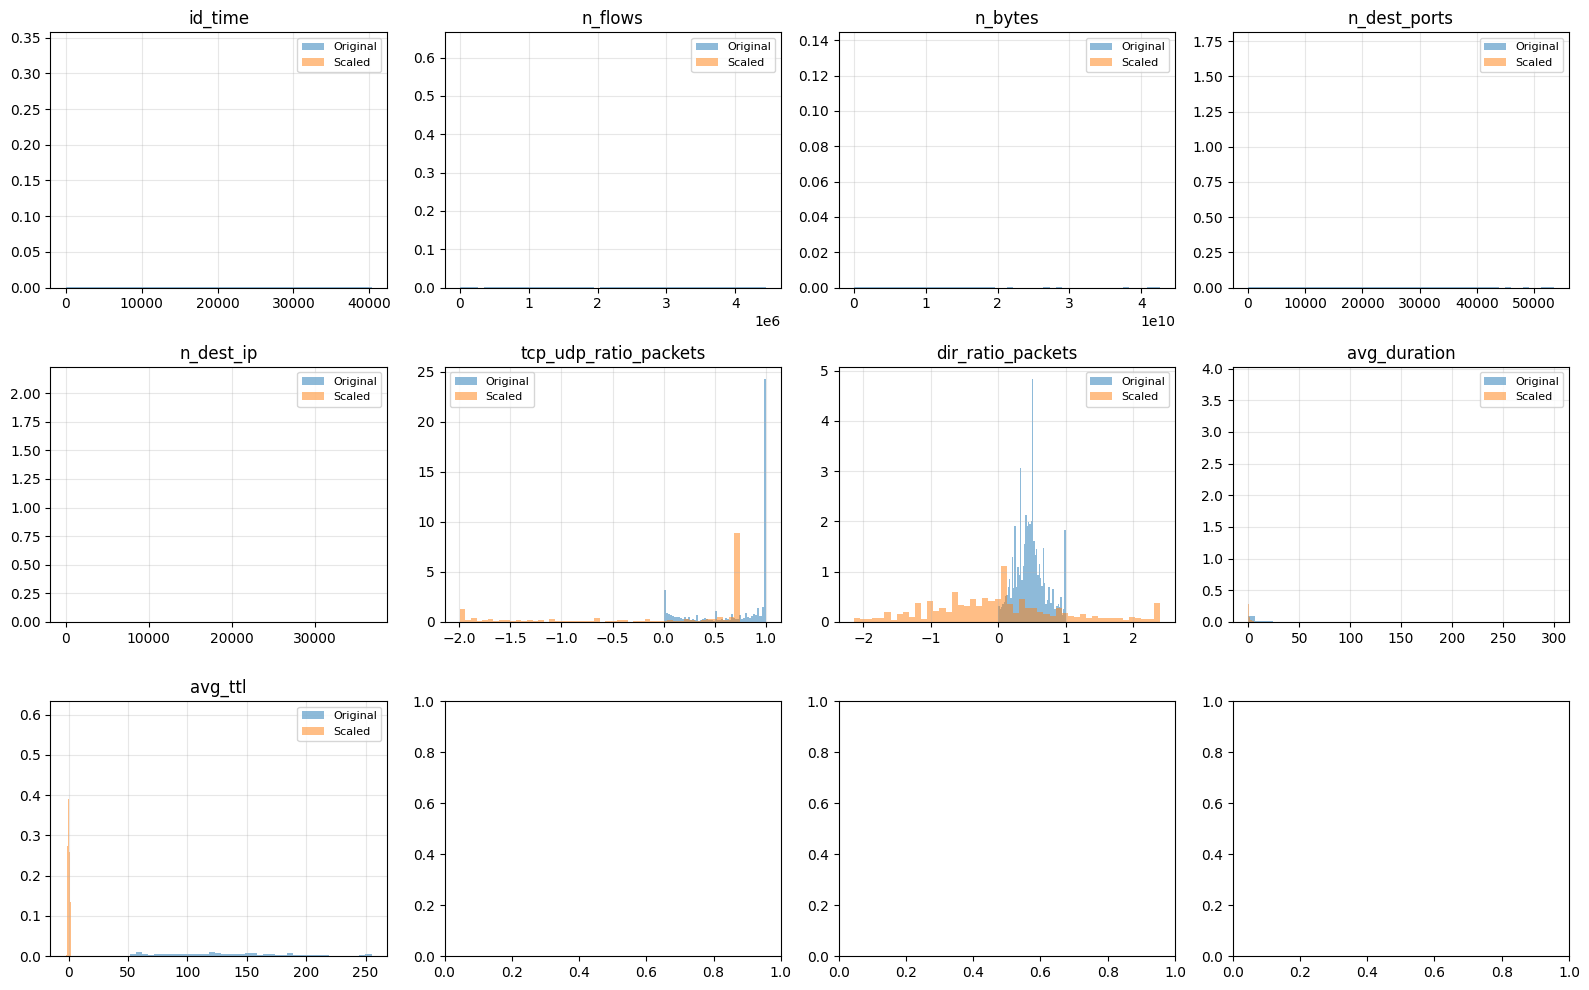

In [ ]:
#visualizations

#distributions
fig, axes = plt.subplots(3, 4, figsize=(16, 10))
axes = axes.ravel()

for idx, col in enumerate(features_to_keep):
    axes[idx].hist(x[col].values, bins=50, alpha=0.5, label='Original', density=True)
    axes[idx].hist(x_scaled_df[col].values, bins=50, alpha=0.5, label='Scaled', density=True)
    axes[idx].set_title(f'{col}')
    axes[idx].legend(fontsize=8)
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

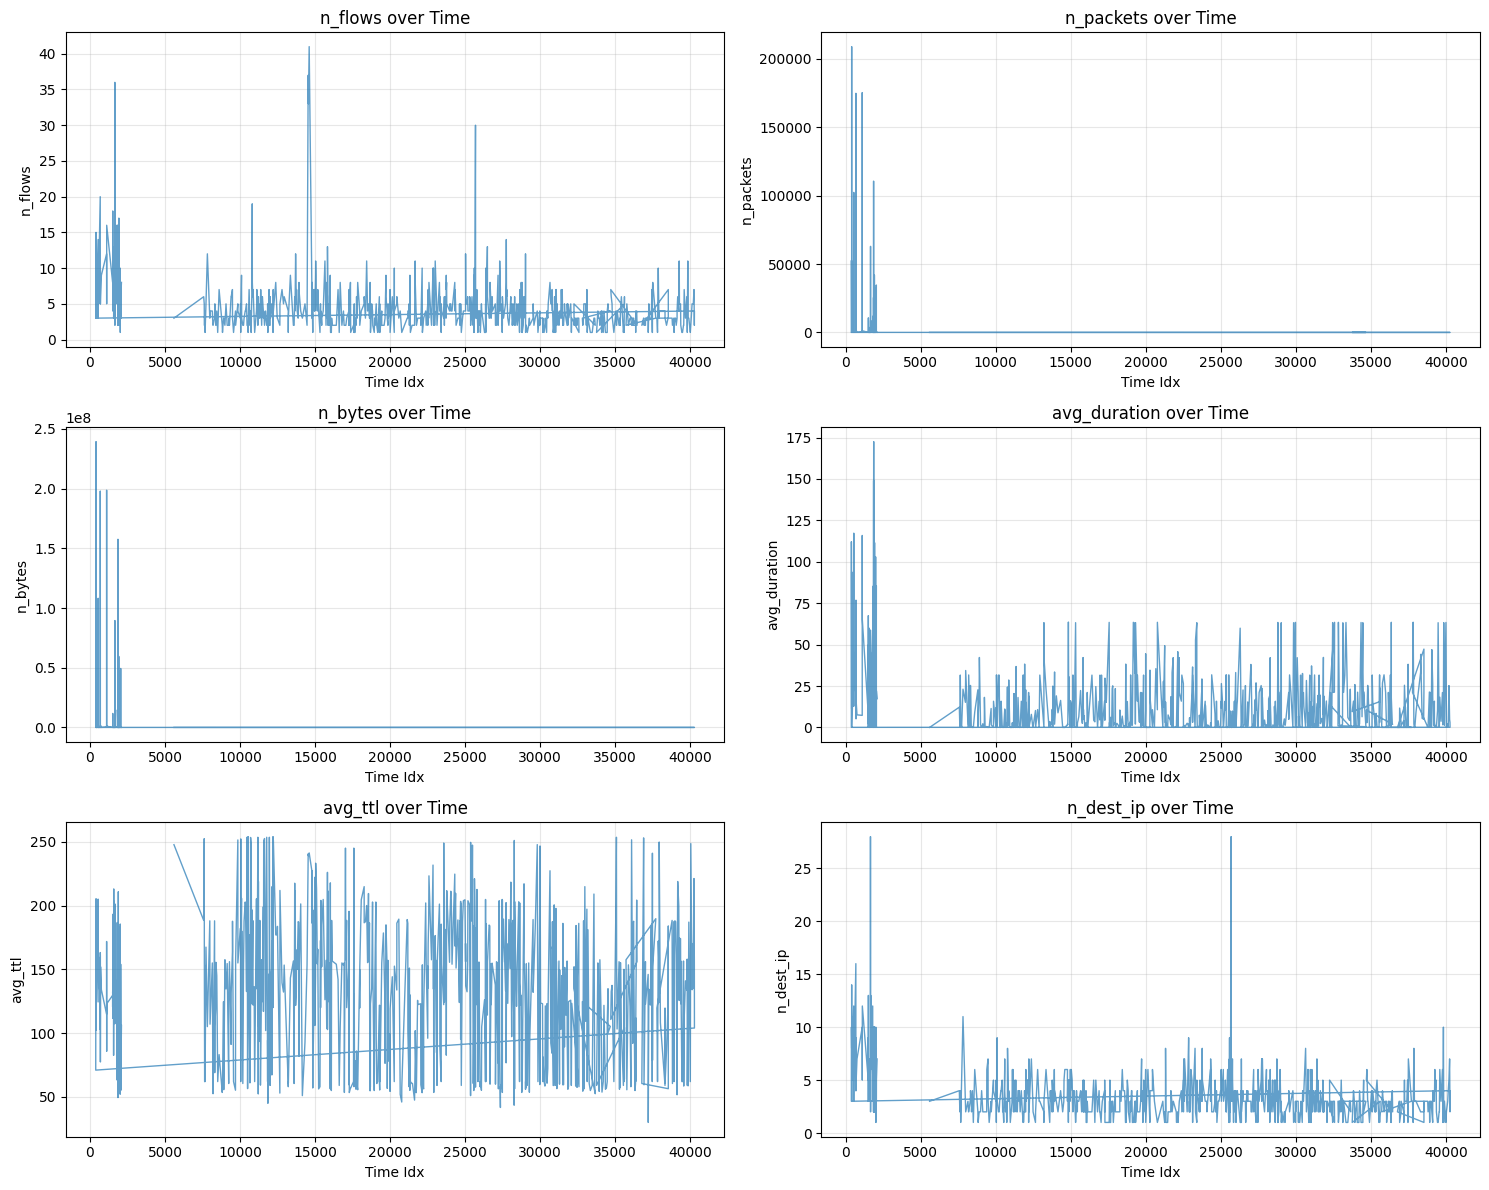

In [ ]:
#time distribution visuals
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
key_metrics = ['n_flows', 'n_packets', 'n_bytes', 'avg_duration', 'avg_ttl', 'n_dest_ip']

for idx, metric in enumerate(key_metrics):
    ax = axes[idx // 2, idx % 2]

    time_pts = df['id_time'].values[:1000]
    metric_vals = df[metric].values[:1000]

    ax.plot(time_pts, metric_vals, alpha=0.7, linewidth=1)
    ax.set_title(f'{metric} over Time')
    ax.set_xlabel('Time Idx')
    ax.set_ylabel(metric)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# split train and test sets (70-30 split)
features_train = r_x_scaled_df[:4807276]
features_test = r_x_scaled_df[-50000:]

# Isolation Forest Model Training

In [ ]:
!pip install netml

In [ ]:
# import IF
from netml.ndm.iforest import IForest
from netml.ndm.model import MODEL
from netml.utils.tool import dump_data, load_data
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

In [ ]:
iforest_model = IForest(contamination=0.3, random_state=42)
iforest_model.fit(features_train)


IForest(behaviour='old', bootstrap=False, contamination=0.3, max_features=1.0,
    max_samples='auto', n_estimators=100, n_jobs=1, random_state=42,
    verbose=0)

# K-Means Training

In [ ]:
# k-means training
from sklearn.model_selection import train_test_split

X_scaled = x_scaled_df.values

print(f"total dataset size: {X_scaled.shape}")
print(f"scaled data - Mean: {X_scaled.mean(axis=0)[:3]}")
print(f"scaled data - Std: {X_scaled.std(axis=0)[:3]}")

x_train, x_test = train_test_split(
    X_scaled,
    test_size=0.3,
    random_state=42,
    shuffle=True
)

print(f"\ntraining set shape: {x_train.shape}")
print(f"test set shape: {x_test.shape}")

print(f"\nx_train - Mean: {x_train.mean(axis=0)[:3]}")
print(f"x_train - Std: {x_train.std(axis=0)[:3]}")

print(f"\nx_test - Mean: {x_test.mean(axis=0)[:3]}")
print(f"x_test - Std: {x_test.std(axis=0)[:3]}")

total dataset size: (6852292, 9)
scaled data - Mean: [-1.52106905e-16 -1.55333868e-17 -4.53682735e-17]
scaled data - Std: [1. 1. 1.]

training set shape: (4796604, 9)
test set shape: (2055688, 9)

x_train - Mean: [-2.21269556e-04 -9.25781743e-05 -9.12091097e-05]
x_train - Std: [1.00009258 0.99667465 1.00212815]

x_test - Mean: [0.0005163  0.00021602 0.00021282]
x_test - Std: [0.99978375 1.00771645 0.99501659]


In [ ]:
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
import time

print(f"dataset size: {x_train.shape}")

SAMPLE_SIZE = 50000

np.random.seed(42)
sample_indices = np.random.choice(len(x_train), SAMPLE_SIZE, replace=False)
x_train_sample = x_train[sample_indices]

print(f"Sample shape: {x_train_sample.shape}")

k_range = range(2, 8)
silhouette_scores = []

start_time = time.time()

for k in k_range:
    print(f"on this k: {k}")
    k_start = time.time()

    kmeans = MiniBatchKMeans(
        n_clusters=k,
        random_state=42,
        batch_size=1000,
        max_iter=50,
        n_init=3
    )

    cluster_labels = kmeans.fit_predict(x_train_sample)
    silhouette_avg = silhouette_score(x_train_sample, cluster_labels)
    silhouette_scores.append(silhouette_avg)

    k_elapsed = time.time() - k_start
    print(f"k={k}: silhouette = {silhouette_avg:.4f} (total time: {k_elapsed:.1f}s)")

total_time = time.time() - start_time
print(f"\n total time: {total_time:.4f}s")
print(f"optimal k: {k_range[np.argmax(silhouette_scores)]}")

dataset size: (4796604, 9)
Sample shape: (50000, 9)
on this k: 2
k=2: silhouette = 0.2313 (total time: 30.9s)
on this k: 3
k=3: silhouette = 0.1709 (total time: 29.8s)
on this k: 4
k=4: silhouette = 0.1563 (total time: 29.2s)
on this k: 5
k=5: silhouette = 0.1437 (total time: 30.0s)
on this k: 6
k=6: silhouette = 0.1740 (total time: 29.4s)
on this k: 7
k=7: silhouette = 0.1955 (total time: 28.3s)

 total time: 177.6031s
optimal k: 2


In [ ]:
#optimal k = 6

chosen_k = 6

final_kmeans = MiniBatchKMeans(
    n_clusters=chosen_k,
    random_state=42,
    batch_size=1000,
    max_iter=200,
    n_init=10,
    verbose=0
)

final_kmeans.fit(x_train_sample)

sample_labels = final_kmeans.labels_
sample_dists = final_kmeans.transform(x_train_sample)
sample_pt_dists = sample_dists[np.arange(len(sample_dists)), sample_labels]

print("cluster distribution:")
unique, counts = np.unique(sample_labels, return_counts=True)

for cluster, count in zip(unique, counts):
    percentage = (count / len(sample_labels)) * 100
    print(f"cluster {cluster}: {count:,} samples ({percentage:.2f}%)")

cluster distribution:
cluster 0: 16,732 samples (33.46%)
cluster 1: 17,348 samples (34.70%)
cluster 2: 5,883 samples (11.77%)
cluster 3: 341 samples (0.68%)
cluster 4: 9,318 samples (18.64%)
cluster 5: 378 samples (0.76%)


In [ ]:
mean_dist = np.mean(sample_pt_dists)
std_dist = np.std(sample_pt_dists)

#2 strategies -> choosing from centroid dist or clusters

#centroid strategy
print("centroid strategy")
print(f"mean distance to centroid: {mean_dist:.4f}")
print(f"std of distances: {std_dist:.4f}")

threshold_multiplier = 2.0
dist_threshold = mean_dist + threshold_multiplier * std_dist

sample_anomalies_dist = sample_pt_dists > dist_threshold
sample_anomaly_pct_dist = np.sum(sample_anomalies_dist) / len(x_train_sample) * 100

print(f"distance threshold: {dist_threshold:.4f}")
print(f"# of anomalies detected: {np.sum(sample_anomalies_dist):,}")
print(f"anomaly %: {sample_anomaly_pct_dist:.2f}%")

# smallest cluster strategy
print("cluster strategy")
if counts[0] < counts[1]:
    anomaly_cluster = 0
    normal_cluster = 1
else:
    anomaly_cluster = 1
    normal_cluster = 0

sample_anomalies_cluster = (sample_labels == anomaly_cluster)
sample_anomaly_pct_cluster = np.sum(sample_anomalies_cluster) / len(x_train_sample) * 100

print(f"normal cluster: Cluster {normal_cluster} ({counts[normal_cluster] / len(x_train_sample)*100:.1f}%)")
print(f"anomaly cluster: Cluster {anomaly_cluster} ({counts[anomaly_cluster] / len(x_train_sample)*100:.1f}%)")
print(f"# of anomalies detected: {np.sum(sample_anomalies_cluster):,}")
print(f"anomaly %: {sample_anomaly_pct_cluster:.2f}%")

print(f"\ncomparing strategies:")
print(f"distance based: {sample_anomaly_pct_dist:.2f}% anomalies")
print(f"cluster based: {sample_anomaly_pct_cluster:.2f}% anomalies")

centroid strategy
mean distance to centroid: 1.7762
std of distances: 1.5330
distance threshold: 4.8423
# of anomalies detected: 701
anomaly %: 1.40%
cluster strategy
normal cluster: Cluster 1 (34.7%)
anomaly cluster: Cluster 0 (33.5%)
# of anomalies detected: 16,732
anomaly %: 33.46%

comparing strategies:
distance based: 1.40% anomalies
cluster based: 33.46% anomalies


In [ ]:
#cluster strategy better
anomaly_cluster = 0
normal_cluster = 1

anomaly_labels_sample = (sample_labels == anomaly_cluster)

print("anomaly stats:\n")
print(f"training sample size: {len(x_train_sample):,}")
print(f"# of anomalies detected: {np.sum(anomaly_labels_sample):,}")
print(f"anomaly %: {np.sum(anomaly_labels_sample)/len(x_train_sample)*100:.2f}%")

anomaly stats:

training sample size: 50,000
# of anomalies detected: 16,732
anomaly %: 33.46%


component 1: 19.73%
component 2: 15.49%
total: 35.22%


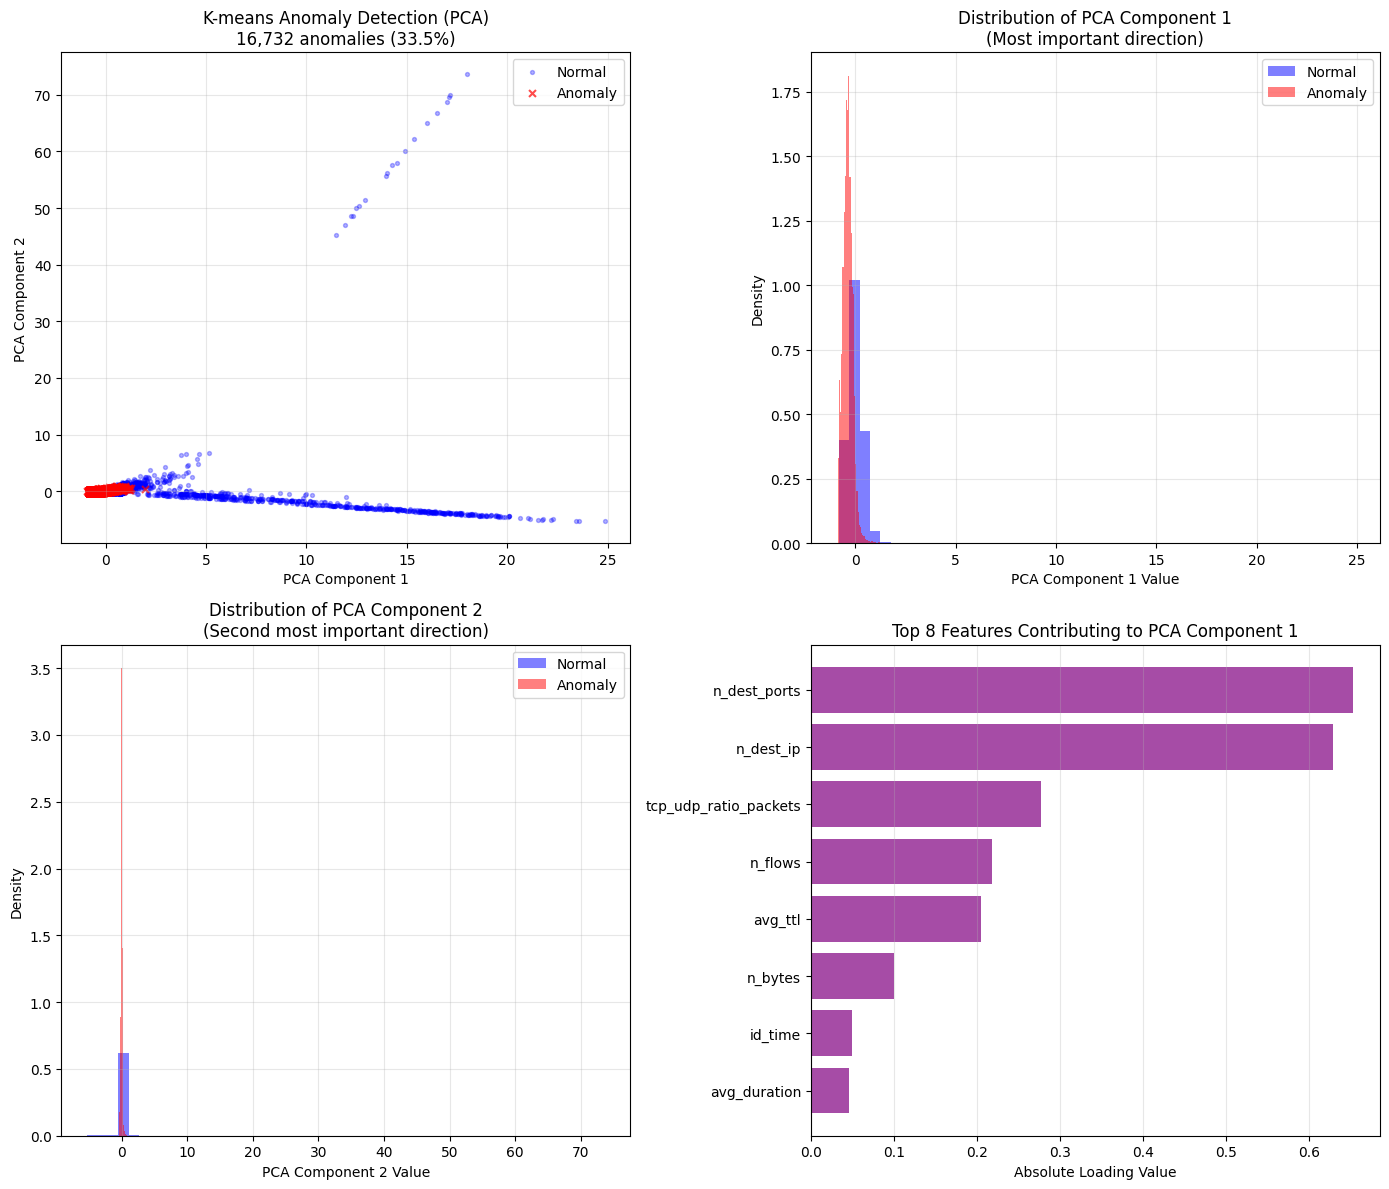

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(x_train_sample)

print(f"component 1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"component 2: {pca.explained_variance_ratio_[1]:.2%}")
print(f"total: {pca.explained_variance_ratio_.sum():.2%}")

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

#normal points = blue
ax1 = axes[0, 0]
normal_mask = ~anomaly_labels_sample
ax1.scatter(X_pca[normal_mask, 0], X_pca[normal_mask, 1], alpha=0.3, s=8, color='blue', label='Normal')

#anomalies = red
kmeans_anomaly_mask = anomaly_labels_sample
ax1.scatter(X_pca[kmeans_anomaly_mask, 0], X_pca[kmeans_anomaly_mask, 1], alpha=0.7, s=25, color='red', marker='x', label='Anomaly')
ax1.set_xlabel('PCA Component 1')
ax1.set_ylabel('PCA Component 2')
ax1.set_title(f'K-means Anomaly Detection (PCA)\n{np.sum(anomaly_labels_sample):,} anomalies ({np.sum(anomaly_labels_sample)/len(x_train_sample)*100:.1f}%)')
ax1.legend()
ax1.grid(alpha=0.3)

#pca 1 plot
ax2 = axes[0, 1]
bins = 50
ax2.hist(X_pca[normal_mask, 0], bins=bins, alpha=0.5, color='blue', label='Normal', density=True)
ax2.hist(X_pca[kmeans_anomaly_mask, 0], bins=bins, alpha=0.5, color='red', label='Anomaly', density=True)
ax2.set_xlabel('PCA Component 1 Value')
ax2.set_ylabel('Density')
ax2.set_title('Distribution of PCA Component 1\n(Most important direction)')
ax2.legend()
ax2.grid(alpha=0.3)

#pca 2 plot
ax3 = axes[1, 0]
ax3.hist(X_pca[normal_mask, 1], bins=bins, alpha=0.5, color='blue', label='Normal', density=True)
ax3.hist(X_pca[kmeans_anomaly_mask, 1], bins=bins, alpha=0.5, color='red', label='Anomaly', density=True)
ax3.set_xlabel('PCA Component 2 Value')
ax3.set_ylabel('Density')
ax3.set_title('Distribution of PCA Component 2\n(Second most important direction)')
ax3.legend()
ax3.grid(alpha=0.3)

#feature contributions
ax4 = axes[1, 1]
feature_loadings = np.abs(pca.components_[0])
top_n = min(8, len(feature_loadings))
top_indices = np.argsort(feature_loadings)[-top_n:][::-1]

if hasattr(x_scaled_df, 'columns'):
    feature_names = x_scaled_df.columns
else:
    feature_names = [f'Feature {i}' for i in range(x_train_sample.shape[1])]

y_pos = np.arange(top_n)
ax4.barh(y_pos, feature_loadings[top_indices], color='purple', alpha=0.7)
ax4.set_yticks(y_pos)
ax4.set_yticklabels([feature_names[i] for i in top_indices])
ax4.set_xlabel('Absolute Loading Value')
ax4.set_title(f'Top {top_n} Features Contributing to PCA Component 1')
ax4.grid(alpha=0.3, axis='x')
ax4.invert_yaxis()

plt.tight_layout()
plt.show()

# DBSCAN Model Training

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
dbscan_model = DBSCAN(eps=0.4, min_samples=5)
dbscan_labels = dbscan_model.fit_predict(x_train_sample)

In [ ]:
db_anomaly_indices = np.where(dbscan_labels == -1)[0]
db_anomaly_percentage = len(db_anomaly_indices) / len(dbscan_labels) * 100
print(f"DBSCAN detected {db_anomaly_percentage:.2f}% anomalies")

DBSCAN detected 10.93% anomalies


component 1: 19.73%
component 2: 15.49%
total: 35.22%


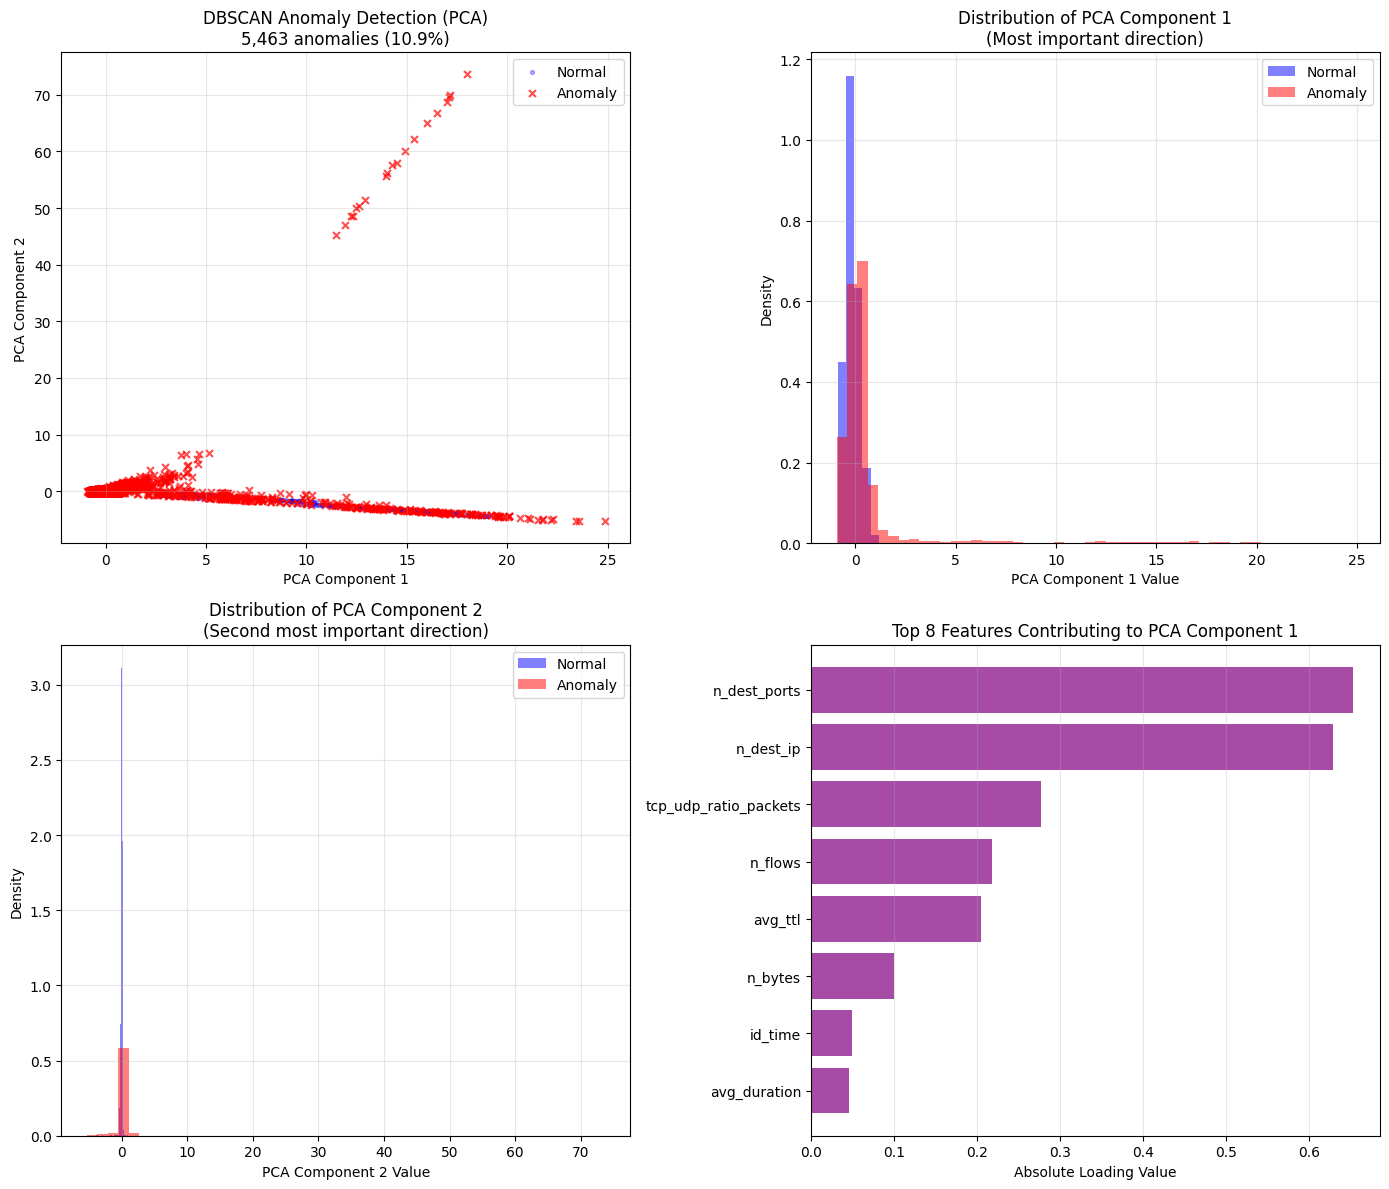

In [ ]:
anomaly_labels_sample = (dbscan_labels == -1)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(x_train_sample)

print(f"component 1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"component 2: {pca.explained_variance_ratio_[1]:.2%}")
print(f"total: {pca.explained_variance_ratio_.sum():.2%}")

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

#normal points = blue
ax1 = axes[0, 0]
normal_mask = ~anomaly_labels_sample
ax1.scatter(X_pca[normal_mask, 0], X_pca[normal_mask, 1], alpha=0.3, s=8, color='blue', label='Normal')

#anomalies = red
db_anomaly_mask = anomaly_labels_sample
ax1.scatter(X_pca[db_anomaly_mask, 0], X_pca[db_anomaly_mask, 1], alpha=0.7, s=25, color='red', marker='x', label='Anomaly')
ax1.set_xlabel('PCA Component 1')
ax1.set_ylabel('PCA Component 2')
ax1.set_title(f'DBSCAN Anomaly Detection (PCA)\n{np.sum(anomaly_labels_sample):,} anomalies ({np.sum(anomaly_labels_sample)/len(x_train_sample)*100:.1f}%)')
ax1.legend()
ax1.grid(alpha=0.3)

#pca 1 plot
ax2 = axes[0, 1]
bins = 50
ax2.hist(X_pca[normal_mask, 0], bins=bins, alpha=0.5, color='blue', label='Normal', density=True)
ax2.hist(X_pca[db_anomaly_mask, 0], bins=bins, alpha=0.5, color='red', label='Anomaly', density=True)
ax2.set_xlabel('PCA Component 1 Value')
ax2.set_ylabel('Density')
ax2.set_title('Distribution of PCA Component 1\n(Most important direction)')
ax2.legend()
ax2.grid(alpha=0.3)

#pca 2 plot
ax3 = axes[1, 0]
ax3.hist(X_pca[normal_mask, 1], bins=bins, alpha=0.5, color='blue', label='Normal', density=True)
ax3.hist(X_pca[db_anomaly_mask, 1], bins=bins, alpha=0.5, color='red', label='Anomaly', density=True)
ax3.set_xlabel('PCA Component 2 Value')
ax3.set_ylabel('Density')
ax3.set_title('Distribution of PCA Component 2\n(Second most important direction)')
ax3.legend()
ax3.grid(alpha=0.3)

#feature contributions
ax4 = axes[1, 1]
feature_loadings = np.abs(pca.components_[0])
top_n = min(8, len(feature_loadings))
top_indices = np.argsort(feature_loadings)[-top_n:][::-1]

if hasattr(X_sample, 'columns'):
    feature_names = X_sample.columns
else:
    feature_names = [f'Feature {i}' for i in range(X_sample.shape[1])]

y_pos = np.arange(top_n)
ax4.barh(y_pos, feature_loadings[top_indices], color='purple', alpha=0.7)
ax4.set_yticks(y_pos)
ax4.set_yticklabels([feature_names[i] for i in top_indices])
ax4.set_xlabel('Absolute Loading Value')
ax4.set_title(f'Top {top_n} Features Contributing to PCA Component 1')
ax4.grid(alpha=0.3, axis='x')
ax4.invert_yaxis()

plt.tight_layout()
plt.show()

# Model Evaluation


In [ ]:
pred_labels = iforest_model.predict(features_test)


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


In [ ]:
scores = iforest_model.decision_function(x_train_sample)


In [ ]:
bin_scores = iforest_model.predict(x_train_sample)

In [ ]:
for t in [0, 0.05, 0.1, 0.2, 0.25]:
    pct = np.mean(scores < t) * 100
    print(f"Scores < {t:>4}: {pct:6.2f}%")


Scores <    0:  74.86%
Scores < 0.05:  95.65%
Scores <  0.1:  98.92%
Scores <  0.2:  99.85%
Scores < 0.25: 100.00%


In [ ]:
thr = np.percentile(scores, 99.29)
custom_anoms = scores > thr
print("Custom anomaly rate:", custom_anoms.mean()*100)

Custom anomaly rate: 0.7100000000000001


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


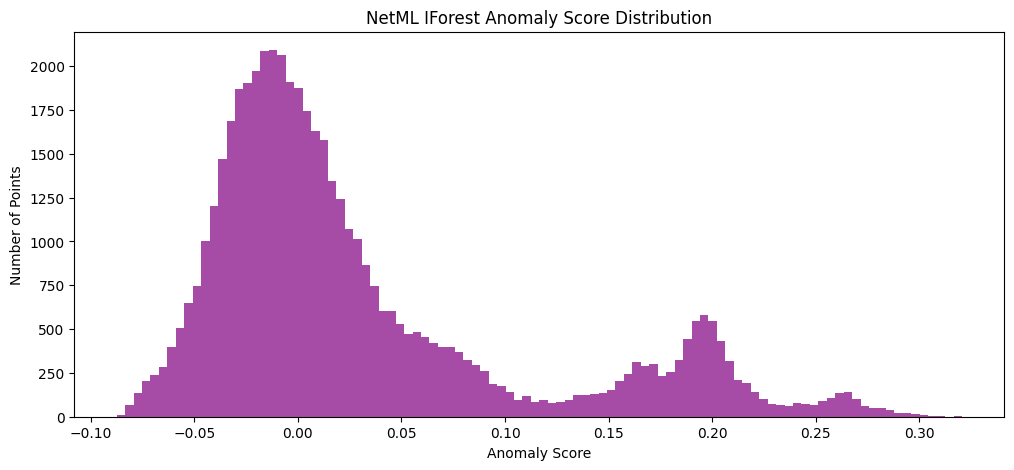

In [ ]:
scores = iforest_model.decision_function(features_test)

plt.figure(figsize=(12,5))
plt.hist(scores, bins=100, color='purple', alpha=0.7)
plt.title("NetML IForest Anomaly Score Distribution")
plt.xlabel("Anomaly Score")
plt.ylabel("Number of Points")
plt.show()


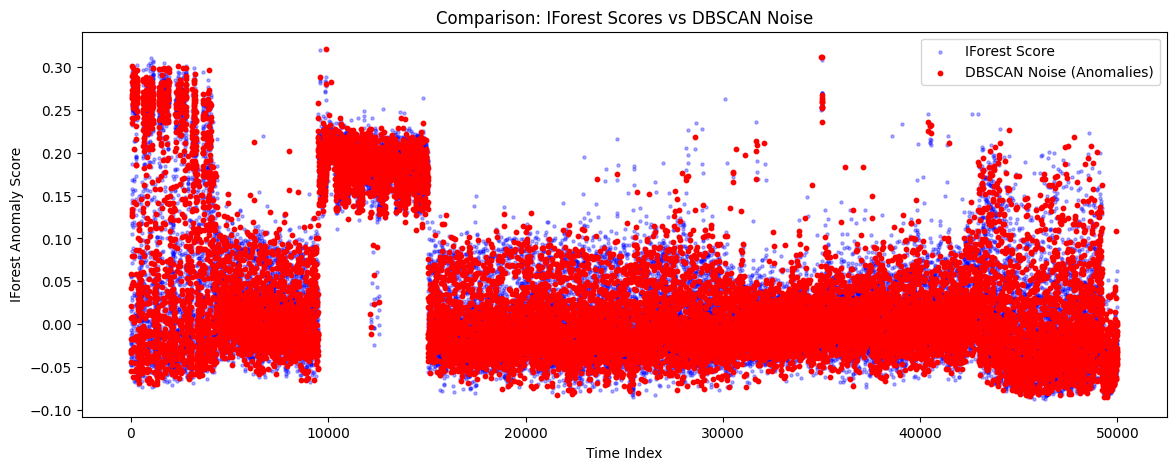

In [ ]:
# Map K-means onto IForest Scores
plt.figure(figsize=(14,5))

# Scatter plot of IForest scores
plt.scatter(np.arange(len(scores)), scores,
            color='blue', alpha=0.3, s=5, label='IForest Score')

# Overlay DBSCAN anomalies
plt.scatter(np.where(kmeans_anomaly_mask)[0], scores[kmeans_anomaly_mask],
            color='red', s=10, label='DBSCAN Noise (Anomalies)')

plt.title("Comparison: IForest Scores vs DBSCAN Noise")
plt.xlabel("Time Index")
plt.ylabel("IForest Anomaly Score")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import davies_bouldin_score

cluster_mask = dbscan_labels != -1
if len(np.unique(dbscan_labels[cluster_mask])) > 1:  # need at least 2 clusters
    dbi = davies_bouldin_score(x_train_sample[cluster_mask], dbscan_labels[cluster_mask])
    print(f"Davies-Bouldin Index (excluding noise): {dbi:.3f}")
else:
    print("Not enough clusters to compute DBI.")

Davies-Bouldin Index (excluding noise): 0.733


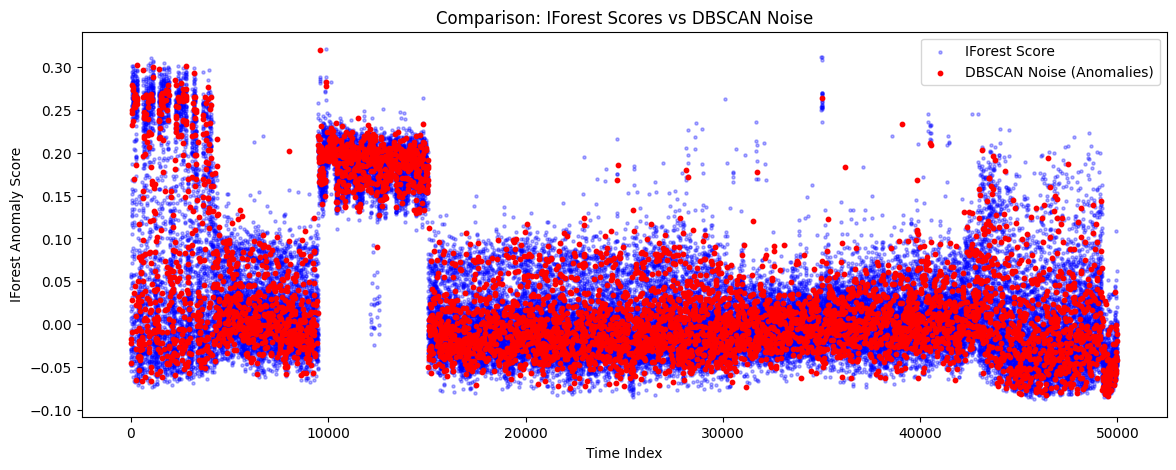

In [ ]:
# Identify DBSCAN anomalies
db_anomaly_mask = dbscan_labels == -1

plt.figure(figsize=(14,5))

# Scatter plot of IForest scores
plt.scatter(np.arange(len(scores)), scores,
            color='blue', alpha=0.3, s=5, label='IForest Score')

# Overlay DBSCAN anomalies
plt.scatter(np.where(db_anomaly_mask)[0], scores[db_anomaly_mask],
            color='red', s=10, label='DBSCAN Noise (Anomalies)')

plt.title("Comparison: IForest Scores vs DBSCAN Noise")
plt.xlabel("Time Index")
plt.ylabel("IForest Anomaly Score")
plt.legend()
plt.show()

# Comparison Metrics



In [ ]:
# K-means vs Isolation Forest
threshold = np.percentile(scores, 99.29)
iforest_anomalies = scores >= threshold

# Overlap between K-meaans and IForest anomalies
overlap_if = np.sum(kmeans_anomaly_mask & iforest_anomalies) / np.sum(kmeans_anomaly_mask) * 100
print(f"Percentage of K-means anomalies also flagged by IForest: {overlap_if:.2f}%")



Percentage of K-means anomalies also flagged by IForest: 0.78%


In [ ]:
# Overlap between K-means and DBSCAN
overlap_k_db = np.sum(kmeans_anomaly_mask & db_anomaly_mask) / np.sum(kmeans_anomaly_mask) * 100

print(f"Percentage of DBSCAN anomalies also flagged by K-means: {overlap_k_db:.2f}%")


Percentage of DBSCAN anomalies also flagged by K-means: 5.13%


In [ ]:
# Overlap between DBSCAN noise and IForest anomalies
overlap_db_if = np.sum(db_anomaly_mask & iforest_anomalies) / np.sum(db_anomaly_mask) * 100
print(f"Percentage of DBSCAN anomalies also flagged by IForest: {overlap_db_if:.2f}%")

Percentage of DBSCAN anomalies also flagged by IForest: 0.46%
